In [21]:
import os

wd = '/Users/riccardoconci/Local_documents/ACS submissions/GeomDL/'
os.chdir(wd)



from TGB.tgb.utils.info import DATA_URL_DICT
from TGB.tgb.linkproppred.dataset import LinkPropPredDataset

import requests
import zipfile
import os
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
import itertools
from itertools import combinations
import pandas as pd
from scipy.stats import wasserstein_distance
from scipy.special import rel_entr

import pickle
import random




### Plotting functions!!

In [22]:

plt.rcParams['axes.titlesize'] = 18  # Title
plt.rcParams['axes.labelsize'] = 16  # Axis labels
plt.rcParams['xtick.labelsize'] = 14 # X-axis tick labels
plt.rcParams['ytick.labelsize'] = 14 # Y-axis tick labels
plt.rcParams['legend.fontsize'] = 14 # Legend


In [23]:
import numpy as np
import matplotlib.pyplot as plt

def plot_sampler_effectiveness_height_with_noise(sub_list, time_diff_count, dataset_name, base_path, plot_every_nth=1):
    sub_list = np.array(sub_list)
    plt.figure(figsize=(10, 8))
    plt.title(f'Sampled Time Differences for {dataset_name}')

    # Calculate the "umbrella" range as +/- 10% for the sub_list
    enhanced_ranges = [(x - 0.1 * x, x + 0.1 * x) for x in sub_list]

    # Normalize time_diff_count for plotting
    total_count = time_diff_count['time_diff_count'].sum()
    normalized_heights = (time_diff_count['time_diff_count'] / total_count) *100
    #max_count = time_diff_count['time_diff_count'].max()
    #normalized_heights = time_diff_count['time_diff_count'] / max_count

    # Flags for legend labels
    label_within_added = False
    label_outside_added = False

    low_value = max(normalized_heights)*0.1

    # Plot with time diffs
    for i, (x, height) in enumerate(zip(time_diff_count['TimeDiff'], normalized_heights)):
        if height < low_value and i % plot_every_nth != 0:
            continue
        
        isInAnyRange = is_in_any_range(x, sub_list)
        color = 'mediumspringgreen' if isInAnyRange else 'pink'
        label = ""
        if isInAnyRange and not label_within_added:
            label = 'Within ±10% Range'
            label_within_added = True
        elif not isInAnyRange and not label_outside_added:
            label = 'Outside ±10% Range'
            label_outside_added = True

        plt.vlines(x, 0, height, colors=color, linewidth=1.5, label=label)

    # Plot blue dots with orange noise lines at y = -0.1
    for i, x in enumerate(sub_list):
        plt.plot(x, -low_value, 'bo', label='Sampled Time Difference' if i == 0 else "")
        plt.hlines(y=-low_value, xmin=x * 0.9, xmax=x * 1.1, color='cyan', linewidth=2, label='Noise Range' if i == 0 else "")

    plt.xscale('log')
    plt.xlabel('Time Difference values (Log Scale)')
    plt.ylabel('Normalized Frequency')
    plt.xticks([10**i for i in range(int(np.log10(min(sub_list))), int(np.log10(max(sub_list)))+1)], rotation=45)

    plt.legend()
    plt.tight_layout()
    save_title = dataset_name + '_sampled_time_diffs_with_noise'
    plt.savefig(base_path + save_title + '.jpg')
    plt.show()

def is_in_any_range(num, sub_list):
    enhanced_ranges = [(x - 0.1 * x, x + 0.1 * x) for x in sub_list]
    return any(lower <= num <= upper for lower, upper in enhanced_ranges)


In [24]:

def calculate_edges_checked(sub_list,noise_value, time_diff_count_df ):
    # Calculate the enhanced (±10%) ranges for each value in the first list
    total_count = time_diff_count_df['time_diff_count'].sum()
    noise_frac = noise_value/100
    enhanced_ranges = [(x - noise_frac * x, x + noise_frac * x) for x in sub_list]
    #print(enhanced_ranges)
    # Function to check if a number falls within any range in a list of ranges
    def is_in_any_range(number, ranges):
        return any(lower <= number <= upper for lower, upper in ranges)

    time_diff_seq = time_diff_count_df['TimeDiff']
    # Collect the values in the second list that fall within any of the enhanced ranges
    included_values = [x for x in time_diff_seq if is_in_any_range(x, enhanced_ranges)]

    #print(f"Values from the second list included in the enhanced first list: {included_values}")

    perc_time_diffs = (len(included_values)/len(time_diff_seq) )* 100
    print(perc_time_diffs)

    filtered_df = time_diff_count_df[time_diff_count_df['TimeDiff'].isin(included_values)]
    num_edges_checked = filtered_df['time_diff_count'].sum()
    perc_edges = (num_edges_checked / total_count)*100
    print(perc_edges)

    return(perc_time_diffs, perc_edges)

### Plotting the recurrency sampling process

In [25]:
pathname = '/Users/riccardoconci/Local_documents/ACS submissions/GeomDL/Pickle_files/tgbl-wiki_train_recurrency_df.pkl'
with open(pathname, 'rb') as file:
    combined_recurrency = pickle.load(file)

combined_recurrency

,Source,Destination,Number_of_Events,Timestamps,N,Noise_value
0,671.0,8935.0,4,"[2273001.0, 2273004.0, 2273007.0, 2273010.0]",3.0,0.3
1,671.0,8935.0,4,"[2273075.0, 2273078.0, 2273081.0, 2273084.0]",3.0,0.3
2,671.0,8935.0,4,"[2273231.0, 2273234.0, 2273237.0, 2273240.0]",3.0,0.3
3,671.0,8935.0,5,"[2273274.0, 2273277.0, 2273280.0, 2273283.0, 2...",3.0,0.3
4,671.0,8935.0,5,"[2273330.0, 2273333.0, 2273336.0, 2273339.0, 2...",3.0,0.3
...,...,...,...,...,...,...
194,331.0,8325.0,4,"[1979374.0, 2149566.0, 2314975.0, 2469980.0]",159030.0,15903.0
195,708.0,8414.0,4,"[203910.0, 359913.0, 522892.0, 683731.0]",159030.0,15903.0
196,815.0,8372.0,4,"[121361.0, 291512.0, 458790.0, 631272.0]",159030.0,15903.0
197,61.0,8283.0,4,"[27330.0, 271996.0, 500830.0, 747109.0]",250406.0,25040.6


15
11.811023622047244
36.660268714011515


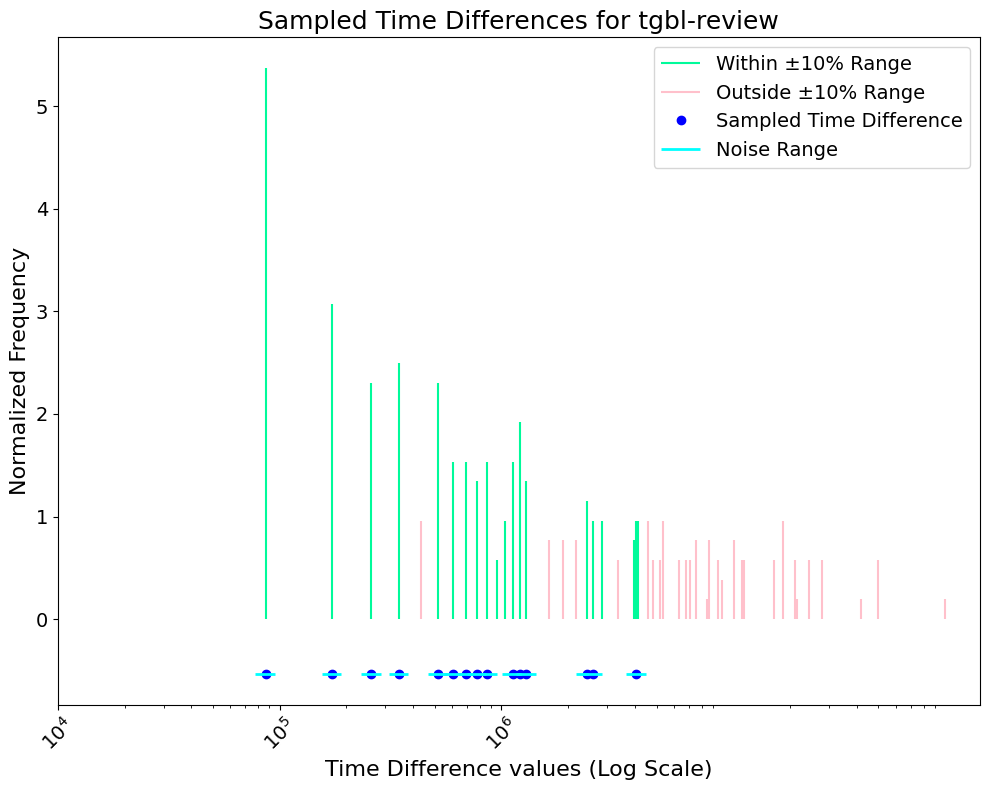

In [26]:
base_pathname = '/Users/riccardoconci/Local_documents/ACS submissions/GeomDL/Pickle_files/'

#dataset_names = ['tgbl-wiki','tgbl-comment', 'tgbl-coin', 'tgbl-flight']
subsets = ['train_recurrency_df', 'train_val_recurrency_df', 'test_recurrency_df']

#recurrent_df_list = [train_rec_df, train_val_rec_df, test_rec_df]

dataset_names = ['tgbl-review']

for name in dataset_names:

    sub_list = []
    recurrent_df_list = []

    for sub in subsets:
        path = base_pathname + name + "_" + sub  + '.pkl'
        with open(path, 'rb') as file:
            recurrent_df = pickle.load(file)
        recurrent_df_list.append(recurrent_df)
        #sub_list.extend(list(recurrent_df['N'].unique()))
        
    path = base_pathname + name + '_time_diff_count_df.pkl'
    with open(path, 'rb') as file:
        time_diff_count_df = pickle.load(file)

    if name =='tgbl-wiki':
        n=1
    elif name =='tgbl-coin':
        n=55
    elif name == 'tgbl-comment':
        n= 76
    elif name == 'tgbl-flight':
        n = 34

    sub_list = sorted(sub_list)
    sub_list = sub_list[:-n] if n < len(sub_list) else []
    
    most_common = time_diff_count_df.sort_values(by='time_diff_count', ascending=False).head(15)['TimeDiff'].tolist()
    sub_list.extend(most_common)

    print(len(sub_list))
    
    base_path = '/Users/riccardoconci/Local_documents/ACS submissions/GeomDL/Plots/'
    if name =='tgbl-wiki':
        plot_every_nth=3
    else:
        plot_every_nth=50
    
    calculate_edges_checked(sub_list,10, time_diff_count_df )
    
    plot_sampler_effectiveness_height_with_noise(sub_list, time_diff_count_df, name, base_path, plot_every_nth )
    






In [20]:
recurrent_df_list

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: []]

In [15]:
combined_recurrent_df = pd.concat(recurrent_df_list)
combined_recurrent_df = combined_recurrent_df.groupby(['Source', 'Destination'])['Timestamps'].agg(sum).apply(sorted).reset_index()
combined_recurrent_df = combined_recurrent_df[['Source', 'Destination', 'Timestamps']]
combined_recurrent_df = combined_recurrent_df.explode('Timestamps').reset_index(drop=True)
combined_recurrent_df = combined_recurrent_df.rename(columns={'Timestamps': 'Timestamp'})



In [16]:

file_name_save = base_pathname + 'tgbl-coin' + '_combined_recurrency_df.pkl'
with open( file_name_save , 'wb') as file: 
    pickle.dump(combined_recurrent_df, file) 


combined_recurrent_df

,Source,Destination,Timestamp
0,4.0,7603.0,1651255102.0
1,4.0,7603.0,1654089827.0
2,4.0,7603.0,1656681417.0
3,4.0,7603.0,1659355521.0
4,4.0,7603.0,1662039259.0
...,...,...,...
164334,638444.0,33.0,1667251811.0
164335,638444.0,33.0,1667253623.0
164336,638444.0,33.0,1667255423.0
164337,638444.0,33.0,1667257211.0


### Creating tables for the recurrency sampling results!!

In [2]:

def relative_recurrency_comp(subset_df, combined_sorted_df, val_threshold, file_path):
    results = {}

    total_edges = len(subset_df)
    training_only = sum(subset_df.groupby(['Source', 'Destination'])['Timestamp'].max() < val_threshold)
    grouped = subset_df.groupby(['Source', 'Destination'])['Timestamp'].agg(['min', 'max'])
    filtered_groups = grouped[(grouped['min'] < val_threshold) & (grouped['max'] > val_threshold)]
    train_and_val = len(filtered_groups)
    test_only = sum(subset_df.groupby(['Source', 'Destination'])['Timestamp'].min() > val_threshold)

    results['% interactions only in training'] = training_only / total_edges * 100
    results['% interactions in train to val'] = train_and_val / total_edges * 100
    results['% interactions only in test'] = test_only / total_edges * 100

    total_recurrent_edges = len(combined_sorted_df)
    training_only_rec = sum(combined_sorted_df.groupby(['Source', 'Destination'])['Timestamp'].max() < val_threshold)
    grouped_rec = combined_sorted_df.groupby(['Source', 'Destination'])['Timestamp'].agg(['min', 'max'])
    filtered_groups_rec = grouped_rec[(grouped_rec['min'] < val_threshold) & (grouped_rec['max'] > val_threshold)]
    train_and_val_rec = len(filtered_groups_rec)
    test_only_rec = sum(combined_sorted_df.groupby(['Source', 'Destination'])['Timestamp'].min() > val_threshold)

    results['% recurrent interactions overall'] = total_recurrent_edges / total_edges * 100
    results['% recurrent interactions only in training'] = training_only_rec / max(training_only, 1)  * 100
    results['% recurrent interactions in train to val'] = train_and_val_rec / max(train_and_val, 1)  * 100
    results['% recurrent interactions only in test'] = test_only_rec / max(test_only, 1) * 100

    # Pickle the results dictionary
    with open(file_path, 'wb') as handle:
        pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)

    return results





In [ ]:
def relative_recurrency_comp(subset_df, combined_recurrent_df, val_threshold, file_path):
    results = {}

    # Convert 'Timestamp' in combined_recurrent_df to list for compatibility in comparisons
    combined_recurrent_df['Timestamp'] = combined_recurrent_df['Timestamp'].apply(lambda x: [x])
    
    # Concatenate and sort timestamps for recurrent interactions, group by 'Source' and 'Destination'
    combined_recurrent = combined_recurrent_df.groupby(['Source', 'Destination'])['Timestamp'].sum().apply(sorted).reset_index()

    # Calculate total counts
    total_edges = len(subset_df)
    total_pairs = subset_df.groupby(['Source', 'Destination']).ngroups
    total_recurrent_edges = len(combined_recurrent_df)
    total_recurrent_pairs = combined_recurrent.groupby(['Source', 'Destination']).ngroups

    # Calculate recurrent interactions for each category
    training_only = subset_df[subset_df.groupby(['Source', 'Destination'])['Timestamp'].transform('max') < val_threshold]
    train_and_val = subset_df.groupby(['Source', 'Destination']).filter(lambda x: x['Timestamp'].min() < val_threshold and x['Timestamp'].max() > val_threshold)
    test_only = subset_df[subset_df.groupby(['Source', 'Destination'])['Timestamp'].transform('min') > val_threshold]

    results['% interactions only in training (full data)'] = len(training_only) / total_edges * 100
    results['% interactions in train to val (full data)'] = len(train_and_val) / total_edges * 100
    results['% interactions only in test (full data)'] = len(test_only) / total_edges * 100



    # Identify recurrent interactions within each category
    training_only_recurrent = pd.merge(training_only, combined_recurrent, on=['Source', 'Destination'], how='inner')
    train_and_val_recurrent = pd.merge(train_and_val, combined_recurrent, on=['Source', 'Destination'], how='inner')
    test_only_recurrent = pd.merge(test_only, combined_recurrent, on=['Source', 'Destination'], how='inner')

    # Calculate percentages
    results['% recurrent interactions overall'] = total_recurrent_edges / total_edges * 100
    results['% recurrent interactions only in training'] = len(training_only_recurrent) / max(len(training_only), 1) * 100
    results['% recurrent interactions in train to val'] = len(train_and_val_recurrent) / max(len(train_and_val), 1) * 100
    results['% recurrent interactions only in test'] = len(test_only_recurrent) / max(len(test_only), 1) * 100

    # Calculate percentages for unique source-destination pairs
    results['% recurrent pairs overall'] = total_recurrent_pairs / total_pairs * 100
    results['% recurrent pairs only in training'] = training_only_recurrent.groupby(['Source', 'Destination']).ngroups / max(training_only.groupby(['Source', 'Destination']).ngroups, 1) * 100
    results['% recurrent pairs in train to val'] = train_and_val_recurrent.groupby(['Source', 'Destination']).ngroups / max(train_and_val.groupby(['Source', 'Destination']).ngroups, 1) * 100
    results['% recurrent pairs only in test'] = test_only_recurrent.groupby(['Source', 'Destination']).ngroups / max(test_only.groupby(['Source', 'Destination']).ngroups, 1) * 100

    # Pickle the results dictionary
    with open(file_path, 'wb') as handle:
        pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)

    return results

In [17]:
base_pathname = '/Users/riccardoconci/Local_documents/ACS submissions/GeomDL/Pickle_files/'
dataset_names = ['tgbl-review']#,'tgbl-comment', 'tgbl-flight']

for name in dataset_names:

    path = base_pathname + name + "_data_df.pkl"
    with open(path, 'rb') as file:
        data_df = pickle.load(file)

    #subset_df = data_df[data_df['count'] >= 0]
    #subset_df = subset_df[subset_df['TimeDiff'] != 0].dropna()
    val_threshold = data_df.iloc[int(0.75*len(data_df))]['Timestamp']
    

    path = base_pathname + name + "_combined_recurrency_df.pkl"
    with open(path, 'rb') as file:
        combined_recurrency_df = pickle.load(file)

    save_filepath = base_pathname + name + '_recurrency_TET.pkl'
    res = relative_recurrency_comp(data_df, combined_recurrency_df, val_threshold, save_filepath)
    print(name)
    print(res)
    

    
    

tgbl-coin
{'% interactions only in training': 11.168848785106338, '% interactions in train to val': 2.594604718405316, '% interactions only in test': 3.1682169427228652, '% recurrent interactions overall': 0.7204853279026103, '% recurrent interactions only in training': 0.6840278745480475, '% recurrent interactions in train to val': 0.8114008408018708, '% recurrent interactions only in test': 0.481004740858004}
